# Applied Data Visualization – Homework 2
*https://www.dataviscourse.net/2023-applied/*


In this homework we will further explore the avalance data by creating custom charts in Matplotlib. 

**Note that you may only use Matplotlib for this homework; no other charting libraries like Seaborn!**

## Your Info and Submission Instructions

* *First name:*
* *Last name:*
* *Email:*
* *UID:*



For your submission, please do the following things: 
* **rename the file to `hw2_lastname.pynb`**
* **include all files that you need to run the homework, including the data file provided** 
* **don't use absolute paths, but usea relative path to the same directory for referencing data**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime


plt.style.use('default')
# This next line tells jupyter to render the images inline
%matplotlib inline
import matplotlib_inline
# This renders your figures as vector graphics AND gives you an option to download a PDF too
matplotlib_inline.backend_inline.set_matplotlib_formats('svg', 'pdf')

## Read & Clean up the Data

You've already done data cleanup in the previous homework, so we'll provide this for you. 

In [2]:
avy_df = pd.read_csv('./avalanches.csv')

# Clean dates and elevation
avy_df['Date'] = pd.to_datetime(avy_df['Date'])
avy_df['Year'] = avy_df['Date'].dt.year.astype('Int64')
avy_df['Month'] = avy_df['Date'].dt.month.astype('Int64')
avy_df['Elevation_Feet'] = pd.to_numeric(avy_df['Elevation'].str.replace('\'', '').str.replace(',', ''))

# Filter out null dates and incomplete years
avy_df = avy_df[avy_df['Date']==avy_df['Date']]
avy_df = avy_df[avy_df['Year'] > 2009]

# Part 1: Violin Plot Per Region

* Create a horizontal violin plot of distributions of avalanche elevations by Region.  
* Sort the regions by the median avalanche elevation in a descending order. 
* Plot the mean on the violing plot. 
* Create lables for the regions that also show the number of avalances in the region. For example: "Salt Lake (3654)"
* Analyze the data. What are trends you see? 

Hints: 
* you'll need to create a series of elevation values for each region 
* Matplotlib violinplots don't like NAN values, make sure to drop them before you try to plot

You can choose your own aesthetics, but make sure it looks good. 

For your reference, here is our solution: 

![Example](violinplot.svg)

In [3]:
# Get a list of all regions
regions = avy_df['Region'].unique()
# the ~ is a bitwise not. You can use it to invert a boolean array
regions = regions[~pd.isna(regions)]

# Create a list of lists of elevations, one per region
data_by_region = [avy_df[avy_df['Region'] == region]['Elevation_Feet'].dropna().tolist() for region in regions]

groups = avy_df[['Region', 'Elevation_Feet']].groupby("Region")

# get a list of series out of the group-by object
region_lists = [group[1] for group in avy_df[['Region', 'Elevation_Feet']].groupby("Region")]

region_series_list = []
for region in region_lists:
    region_series = region['Elevation_Feet'].dropna().reset_index(drop=True)
    region_series.name = region["Region"].iloc[0] + " (" + str(region["Elevation_Feet"].count()) + ")"
    region_series_list.append(region_series)


# Sort by median value, descending
region_series_list.sort(key = lambda x: x.median(), reverse = True)

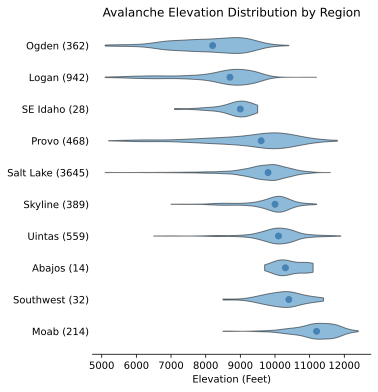

In [4]:
# Calculate medians by region
medians = [region_series.median() for region_series in region_series_list]

# Calculate positions for regions
positions = range(1, len(regions) + 1)

# Create the violin plot
fig, subfig = plt.subplots(figsize=(5, 6))


parts = subfig.violinplot(dataset = region_series_list, positions=positions, vert=False, showextrema=False)
subfig.scatter(x = medians, y = positions, color = 'steelblue')

for pc in parts['bodies']:
    pc.set_edgecolor('black')
    pc.set_alpha(0.5)


# Add labels and a title
subfig.set_label("Region")
subfig.set_xlabel("Elevation (Feet)")
subfig.set_title("Avalanche Elevation Distribution by Region")
subfig.spines['top'].set_visible(False)
subfig.spines['right'].set_visible(False)
subfig.spines['left'].set_visible(False)

subfig.tick_params(axis='y', length=0)

region_lables = [region_series.name for region_series in region_series_list]

# Customize y-axis labels
subfig.set_yticks(positions, labels = region_lables)

### Your Analysis: 

**DELETE** 
Avalanches in the south of Utah are at higher elevations, there are no low-elevation avalances there. The Uintas also have high-elevation avalanches, but go down further than the southern regions. The Wasatch Front sees avalances in a wide range of elevations. 

# Part 2: Radial Bar Chart

* Create a radial bar chart of the average number of avalanches in a year by Aspect.
* Arrange the aspects in the usual convention (North at the top, West on the left, etc.).
* Color the barchart using a cyclic colormap (e.g., HSV).
* Provide an analysis.

Hints: 
* Here is some useful reading: [https://matplotlib.org/stable/api/projections/polar.html](https://matplotlib.org/stable/api/projections/polar.html)

Here is our solution: 

![A radial visualization of avalanches per aspect](radial.svg)

In [5]:
# Dictionary to convert from aspect name to bearing in degrees
aspect2bearing = {
    aspect:bearing for aspect, bearing in zip(
        ['North', 'Northeast', 'East', 'Southeast', 'South', 'Southwest', 'West', 'Northwest'], 
        range(0, 360, 45)
        )
    }

# Summarize the number of avalanches by aspect
count_by_aspect_year = avy_df.groupby(['Year', 'Aspect']).count().reset_index()[['Aspect', 'Year', 'Date']]
count_by_aspect = count_by_aspect_year.groupby('Aspect').aggregate(count_per_year = ('Date', 'mean')).reset_index()

# Add bearing column
count_by_aspect['bearing'] = count_by_aspect['Aspect'].map(lambda x: aspect2bearing[x])
count_by_aspect['theta'] = count_by_aspect['bearing'].map(lambda x: x * 2*np.pi / 360)

Text(0.5, 1.0, 'Mean Annual Avalanches by Aspect')

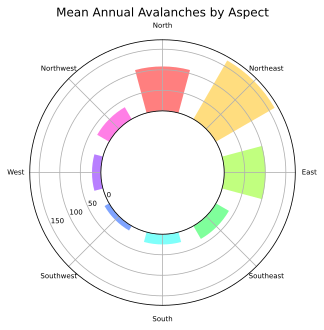

In [6]:
ax = plt.subplot(projection = 'polar')
ax.set_theta_zero_location('N')
ax.set_theta_direction(-1)
ax.set_rorigin(-150)
ax.set_xticks(ticks = count_by_aspect['theta'], labels = count_by_aspect['Aspect'], fontsize = 7)
ax.set_rgrids([0, 50, 100, 150], angle = 245, fontsize = 7)
ax.bar(
    x = count_by_aspect['theta'], 
    height = count_by_aspect['count_per_year'], 
    color = plt.cm.hsv(count_by_aspect['theta'].map(lambda x : x / (2*np.pi))),
    alpha = 0.5, 
    width = np.pi/6
    )
ax.set_title('Mean Annual Avalanches by Aspect')


### Your Analysis: 

**DELETE** The majority of avalanches happens in northern to eastern aspects, with Northeast being the most common aspect for avalanches. 

# Part 3: Rolling average area subplots

* Create a chart where each subfigure is an area chart of the 7-day rolling average of the number of avalanches in a given ski season. Assume that a "ski season" starts July 1 and ends June 31.
* The subplots should overlap so that outliers are less of a problem.
* Provide an analysis of the data. 

Useful methods to consider: 
- Pandas's `.rolling()`
- matplotlib's `.fill_between()`, `.set_axis_off()`, `.tight_layout()`
- datetime's `.timetuple().tm_yday`

Make sure to check out the arguments of the above methods.

Here's how your result should look: 

![A series of line charts showing avalanches over time](line.svg)

In [7]:
def IsLeapYear(year):
  if year % 400 == 0:
    return True
  elif year % 100 == 0:
    return False
  elif year % 4 == 0:
    return True
  else:
    return False

def DayOfSeason(d):

    is_leap_year = IsLeapYear(d.year)
    day_of_year = d.timetuple().tm_yday

    # Set the season start date to July 1
    season_start = 183 if is_leap_year else 182

    day_of_season = day_of_year - season_start if day_of_year > season_start else day_of_year - season_start + 365

    return day_of_season

# Count number of avalanches by date
avy_by_day = avy_df.groupby(['Date']).agg(count = ('Date', 'count')).reset_index()

# Expand the data set to include all dates---even ones without avalanches---for the whole period
avy_by_day = (
  avy_by_day
  .set_index('Date')
  .reindex(pd.date_range('2009-07-01', max(avy_df['Date']), freq = 'D'))
  .rename_axis(['Date'])
  .fillna(0)
  .reset_index()
)

# Calculate year, day # of the ski season, and the ski season
avy_by_day['year'] = avy_by_day['Date'].dt.year
avy_by_day['day_of_season'] = avy_by_day['Date'].apply(lambda x: DayOfSeason(x))
avy_by_day['season'] = avy_by_day.apply(
    lambda x: 
      f"{x['year']}/{x['year']-2000+1}" 
      if x['Date']>=pd.to_datetime(f"{x['year']}-07-01") 
      else f"{x['year']-1}/{x['year']-2000}"
    , axis = 1
)

# Calculate a rolling 7-day average daily avalanche count
avy_by_day['7day_rolling'] = avy_by_day['count'].rolling(7).mean()

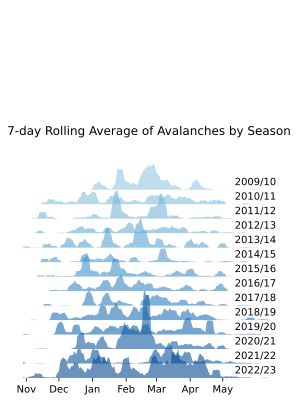

In [8]:
seasons = np.unique(avy_by_day['season'])

fig, subfigs = plt.subplots(
    nrows   = len(seasons), 
    ncols   = 1, 
    figsize = (4, 6)
)

i=0

for season, subfig in zip(seasons, subfigs):

    # Create area plot of rolling average
    subfig.fill_between(
        x  = avy_by_day[avy_by_day['season'] == season]['day_of_season'],
        y1 = avy_by_day[avy_by_day['season'] == season]['7day_rolling'],
        color = plt.cm.Blues(100+10*i),
        edgecolor = 'none',
        alpha = 0.6
    )

    # Set axis limits
    subfig.set_xlim(120, 355)
    subfig.set_ylim(0, 100)

    # Remove borders, axis ticks, labels, grid
    subfig.spines['top'].set_visible(False)
    subfig.spines['right'].set_visible(False)
    subfig.spines['bottom'].set_visible(False)
    subfig.spines['left'].set_visible(False)
    subfig.grid(False)
    subfig.title.set_visible(False)
    subfig.set_yticklabels([])
    subfig.set_yticks([])
    subfig.set_facecolor('none')

    # Keep x-axis labels only for bottom subfigure
    if season != '2022/23':
        subfig.set_xticklabels([])
        subfig.set_xticks([])
    else:
        subfig.set_xticks([DayOfSeason(datetime.date(2022, x, 1)) for x in [11,12,1,2,3,4,5]])
        subfig.set_xticklabels(['Nov', 'Dec', 'Jan', 'Feb', 'Mar', 'Apr', 'May'])


    # Add season label
    subfig.text(
        x = 315, 
        y = 2.5, 
        s = season
    )

    i+=1

fig.suptitle('7-day Rolling Average of Avalanches by Season', y = 0.65)
plt.tight_layout(h_pad=-17)
plt.show()
    

### Your Analysis: 

**DELETE:** Generally, avalanches seem to come in waves, probably correlated with storms. Some years are significantly less active than others. The 22/23 season is very active throughout, the 20/21 season has a massive outlier in late February. 